# 프로젝트 : CIFAR-10 이미지 생성하기
GAN을 학습하는 과정은 보기보다 까다롭습니다. 모델 구조, learning_rate, 파라미터 초기화, 생성자와 판별자의 경쟁 관계, 데이터의 특성 등 고려해야 할 것이 참 많습니다.

이번에는 앞에서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 봅시다.
모델 구현 및 학습의 전과정의 흐름은 거의 비슷하겠지만, 아래와 같이 몇 가지 달라지는 점이 있습니다.

- 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
- 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.
- 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

## 목차
[STEP 0. 작업환경 구성하기](#STEP-0.-작업환경-구성하기)  
[STEP 1. 데이터셋 구성하기](#STEP-1.-데이터셋-구성하기)  
[STEP 2. 생성자 모델 구현하기](#STEP-2.-생성자-모델-구현하기)  
[STEP 3. 판별자 모델 구현하기](#STEP-3.-판별자-모델-구현하기)  
[STEP 4. 손실함수와 최적화 함수 구현하기](#STEP-4.-손실함수와-최적화-함수-구현하기)  
[STEP 5. 훈련과정 상세 기능 구현하기](#STEP-5.-훈련과정-상세-기능-구현하기)  
[STEP 6. 학습 과정 진행하기](#STEP-6.-학습-과정-진행하기)  
[STEP 7. (optional) GAN 훈련 과정 개선하기](#STEP-7.-(optional)-GAN-훈련-과정-개선하기)  
[Rubric](#Rubric)  
[회고](#회고)

## STEP 0. 작업환경 구성하기
---
다음과 같이 작업환경을 구성합시다.

In [1]:
# pip list | grep -E 'imageio|Pillow'
# pip install imageio
# pip install Pillow

In [54]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


In [3]:
# !mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
# !mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
# !mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

## STEP 1. 데이터셋 구성하기
---
CIFAR-10 데이터셋도 `tf.keras` 안에 있는 `datasets`에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋을 구성할 수 있습니다.

In [4]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

- 학습에 사용할 `train_x`의 이미지를 **-1, 1**로 정규화합니다.
- 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

In [5]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [6]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [7]:
train_x.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


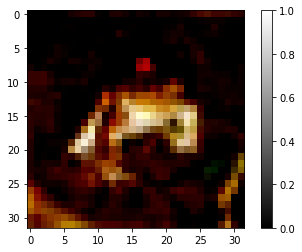

In [8]:
plt.imshow(train_x[0].reshape(32, 32, 3), cmap='gray')
plt.colorbar()
plt.show()

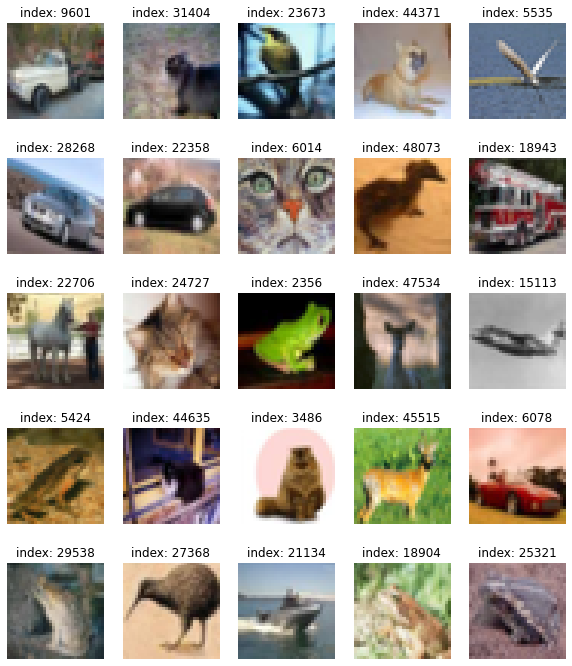

In [9]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    rand_index = np.random.randint(1, 50000)
    plt.imshow((train_x[rand_index]+1)/2)
    plt.title(f'index: {rand_index}')
    plt.axis('off')
plt.show()

In [10]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [13]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

## STEP 2. 생성자 모델 구현하기
---
- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
- `noise = tf.random.normal([1, 100])`로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

In [14]:
noise = tf.random.normal([1, 100])

In [15]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


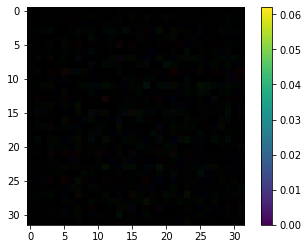

In [16]:
plt.imshow(generated_image[0])
plt.colorbar()
plt.show()

## STEP 3. 판별자 모델 구현하기
---
- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [17]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [18]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [19]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00512369]], dtype=float32)>

## STEP 4. 손실함수와 최적화 함수 구현하기
---
- 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
- 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

In [272]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [273]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [274]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [275]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [276]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

In [277]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## STEP 5. 훈련과정 상세 기능 구현하기
---
- 1개 미니배치의 훈련 과정을 처리하는 `train_step()` 함수를 구현해 봅시다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 `generate_and_save_images()` 함수를 구현해 봅시다.
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 `draw_train_history()` 함수를 구현해 봅시다.
- `training_checkpoints` 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

In [278]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [279]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    predictions = (predictions + 1)/2
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [280]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [281]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 6. 학습 과정 진행하기
---
- 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
- 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

(참고) 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다. 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것입니다.
우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.
아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시입니다.

In [282]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [232]:
save_every = 5
EPOCHS = 500

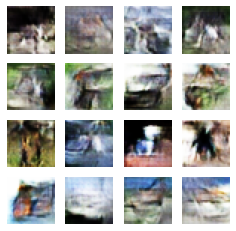

Time for training : 14700 sec


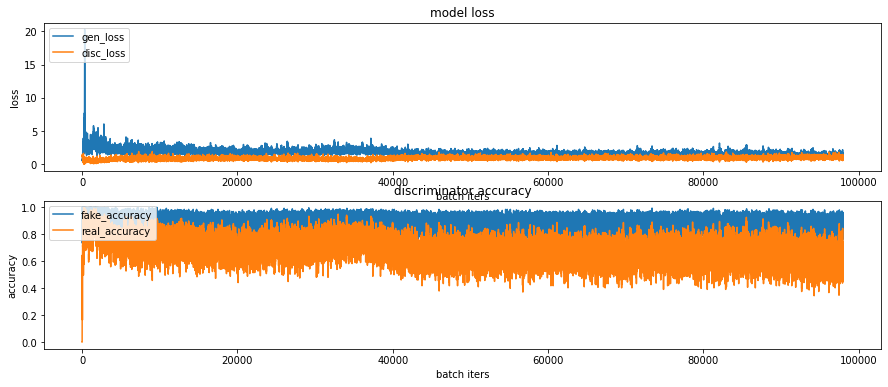

CPU times: user 4h 4min 51s, sys: 4min 21s, total: 4h 9min 13s
Wall time: 4h 5min 3s


In [32]:
%%time
train(train_dataset, EPOCHS, save_every)

In [33]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 3979131 Sep  2 09:32 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


![cifar10_dcgan](https://user-images.githubusercontent.com/68702978/131905633-c8c7a9e7-5b8e-445b-954e-aac86be866c3.gif)
FASHION_MNIST의 grayscale에서 CIFAR10의 RGB의 이미지를 처리하기 위한 모델의 수정 외에 모델의 수정을 거의 거치지 않은 모델의 결과값이다.
(EPOCHS, Optimizer의 Epsilon 정도만 조금 수정되었다.)

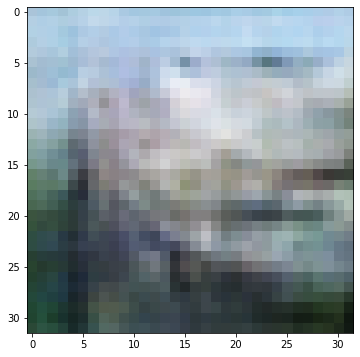

In [34]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

checkpoint를 통해 모델이 로드되었으면 아래 코드를 실행할 경우 로드된 모델의 파라미터 상태에서 훈련을 재개할 수도 있습니다.

## STEP 7. (optional) GAN 훈련 과정 개선하기
---
- STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
- 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.

(참고) 아래 언급된 페이지들에서 개선을 위한 아이디어를 얻을 수 있을 것입니다.

- [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
- [10 Lessons I Learned Training GANs for one Year](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)
- [Tips for Training Stable Generative Adversarial Networks](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)
- [Improved Techniques for Training GANs(paper)](https://papers.nips.cc/paper/6125-improved-techniques-for-training-gans.pdf)

In [283]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [284]:
generator = make_generator_model()
generator.summary()
generated_image = generator(noise, training=False)

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_45 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_106 (LeakyReLU)  (None, 16384)             0         
_________________________________________________________________
reshape_15 (Reshape)         (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_45 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_46 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_107 (LeakyReLU)  (None, 8, 8, 128)       

In [285]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Fifth: Flatten Layer
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [286]:
# def make_discriminator_model():

#     # Start
#     model = tf.keras.Sequential()

#     # First: Conv2D Layer
#     model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     # Second: Conv2D Layer
#     model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     # Third: Flatten Layer
#     model.add(layers.Flatten())

#     # Fourth: Dense Layer
#     model.add(layers.Dense(1))

#     return model

In [287]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_109 (LeakyReLU)  (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
leaky_re_lu_110 (LeakyReLU)  (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 4, 4, 128)         147584    
_________________________________________________________________
leaky_re_lu_111 (LeakyReLU)  (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 2, 2, 128)       

In [288]:
decision = discriminator(generated_image, training=False)

In [289]:
generator_optimizer = tf.keras.optimizers.Adam(epsilon=2e-07)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5, epsilon=2e-07)

In [290]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    predictions = (predictions + 1)/2
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples_2/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [291]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history_2/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [292]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints_2'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [293]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [294]:
save_every = 5
EPOCHS = 500

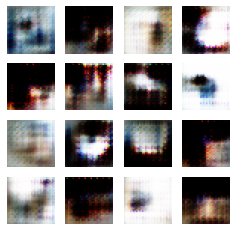

Epoch 7 | iter 51
Time for epoch 7 : 7 sec


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

In [ ]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples_2/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan2.gif

- **참고자료를 통해 discrimination model의 계층을 새로 쌓아주었다.**   
(Conv2D 계층을 늘려주고, Dropout층을 줄여준다거나, 파라미터 등을 조금씩 수정)
- **처음 모델로부터 늘렸던 EPOCHS를 500으로 유지했다.**

In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints_2'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

#### 참고
[How to Develop a GAN to Generate CIFAR10 Small Color Photographs](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/)

## Rubric

||**평가 문항**|**상세 기준**|
|:--------|:--------|:--------|
|**1**|GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.|오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.|
|**2**|생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.|gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.|
|**3**|추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.|제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.|

#### 1 GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.
#### 2 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.
#### 3 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.

## 회고

말로만 듣던 GAN에 대한 프로젝트를 진행하며, 근래 진행했던 노드들 중 가장 흥미롭게 진행하였다.

### 알게된 점
진행하면서, 모델의 개선을 하는데 있어 특히 우용님에게 많은 도움을 받아 좀 더 잘 이해하면서 진행할 수 있었다. 처음 이미지를 -1, 1 사이의 값으로 정규화 하였지만, 사진의 출력 시, 사진이 어둡게 나온다던지 하는 문제를 개선하기 위해 0, 1 사이의 값으로 다시 정규화하는 등의 이미지 처리를 하면서 진행하였다.

### 느낀 점
- 모델이 생성자와 판단자로 서로 개선을 시키는 방향으로 모델을 개선시키는 구동 원리도 흥미로웠고, 시각적으로 개선이 이루어지는 과정이 시각화를 통해 시시각각 나타나는 것이 상당히 흥미로웠다.
- 하지만 그만큼 모델을 train하는 데 걸리는 시간이 오래 걸려 다양한 시도를 하기에는 한계가 있어서 많이 아쉬웠다. 
- GAN에 대해 관심이 많이 생겼고, 더 다양한 종류에 대해 공부를 해보고 싶어졌다.